# Convolutional Neural Network Using Mel Spectrogram Classifying Gender

In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
audio_data = np.load("../data/audio_data.npy")
labels = np.load("../data/wav_labels.npy")

# labels: modality-vocal channel-emotion-emotional intensity-statement-repetition-actor
# emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# odd number actors = male, even = female

# 1440 files: 24 speakers, 60 recordings per speaker
audio_data = audio_data.reshape(1440, 9480)

features = []

for i in range(1440):
    
    if (labels[i][6]%2 == 0):
        label = "Female"
    else:
        label = "Male"

    if (labels[i][2] == 1):
        em = 0
    elif (labels[i][2] == 2):
        em = 1
    elif (labels[i][2] == 3):
        em = 2
    elif (labels[i][2] == 4):
        em = 3
    elif (labels[i][2] == 5):
        em = 4
    elif (labels[i][2] == 6):
        em = 5
    elif (labels[i][2] == 7):
        em = 6
    elif (labels[i][2] == 8):
        em = 7
    
    features.append([audio_data[i], label, em])
    
feature_df = pd.DataFrame(features, columns = ["mfcc", "gender", "emotion"])

feature_df.head()


,mfcc,gender,emotion
0,"[-855.3770751953125, -855.3770751953125, -855....",Male,0
1,"[-850.3917236328125, -850.435791015625, -850.4...",Male,0
2,"[-849.78369140625, -848.8447265625, -848.56610...",Male,0
3,"[-842.9385375976562, -843.2474975585938, -850....",Male,0
4,"[-911.1758422851562, -910.4053344726562, -905....",Male,1


In [3]:
#split data - males vs females
mal = feature_df.loc[feature_df['gender'] == "Male"]
fem = feature_df.loc[feature_df['gender'] == "Female"]

## ===== Females ===== ##
X_females_unscaled = np.array(fem.mfcc.tolist())
y_females = np.array(fem.emotion.tolist())

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_females_unscaled)
X_females_scaled = scaler.transform(X_females_unscaled)

#20-80 train-test split
X_train_females, X_test_females, y_train_females, y_test_females = train_test_split(X_females_scaled, y_females, test_size=0.20, random_state=0)

In [4]:
# Reshape for CNN input
X_train_females = np.array([x.reshape( (20, 474, 1) ) for x in X_train_females])
X_test_females = np.array([x.reshape( (20, 474, 1) ) for x in X_test_females])

# One-Hot encoding for classes
y_train_females = np.array(to_categorical(y_train_females, 8))
y_test_females = np.array(to_categorical(y_test_females, 8))

In [5]:
model = Sequential()

model.add(Conv2D(64, (5,5), input_shape=X_test_females.shape[1:], kernel_regularizer=l2(l=0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(24, (4,4)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.1))

model.add(Conv2D(24, (3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.2))

model.add(Conv2D(80, (2,2)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(rate=0.5))
model.add(Dense(8))
model.add(Activation('softmax'))

In [6]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy']
)

history = model.fit(
	x=X_train_females,
	y=y_train_females,
    epochs=100,
    batch_size=75,
    validation_data= (X_test_females, y_test_females)
)

score = model.evaluate(
	x=X_test_females,
	y=y_test_females)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
8/8 [==============================] - 1s 180ms/step - loss: 2.0952 - accuracy: 0.1458 - val_loss: 2.0876 - val_accuracy: 0.1319
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 2.0773 - accuracy: 0.1424 - val_loss: 2.0790 - val_accuracy: 0.2292
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 2.0520 - accuracy: 0.1927 - val_loss: 2.0554 - val_accuracy: 0.2778
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 1.9961 - accuracy: 0.2274 - val_loss: 1.9900 - val_accuracy: 0.2708
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 1.9149 - accuracy: 0.2847 - val_loss: 1.8731 - val_accuracy: 0.3472
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 1.7849 - accuracy: 0.3003 - val_loss: 1.7349 - val_accuracy: 0.4028
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 1.6880 - accuracy: 0.3628 - val_loss: 1.7053 - val_accuracy: 0.3750
Epoch 8/100
8/8 [==

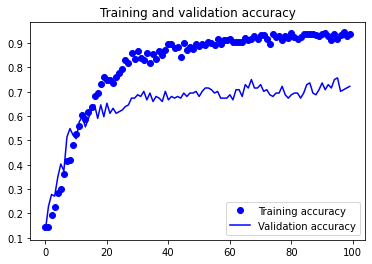

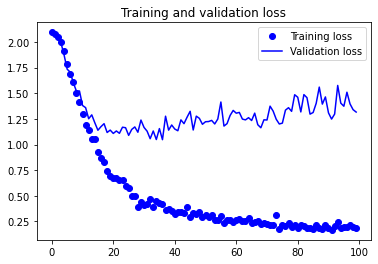

In [7]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()